<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

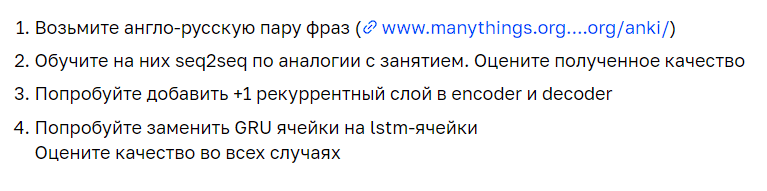

In [1]:
%matplotlib inline

In [2]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2024-07-12 19:05:59--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16305013 (16M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.55M  26.8MB/s    in 0.6s    

2024-07-12 19:06:00 (26.8 MB/s) - ‘rus-eng.zip’ saved [16305013/16305013]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [4]:
!tail /content/rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/content/rus.txt', encoding='utf-8').read().strip().split('\n')

    # Filter out lines that contain the CC-BY metadata
    filtered_lines = [line.split("CC-BY")[0].strip() for line in lines]

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in filtered_lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ru', True)
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 28719 sentence pairs
Counting words...
Counted words:
ru 10274
eng 4305
['я рад что ты мне напомнила .', 'i m glad you reminded me .']


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [19]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)

1m 10s (- 16m 25s) (5000 6%) 3.0866
2m 16s (- 14m 50s) (10000 13%) 2.6209
3m 18s (- 13m 12s) (15000 20%) 2.3359
4m 23s (- 12m 4s) (20000 26%) 2.1619
5m 25s (- 10m 50s) (25000 33%) 1.9764
6m 28s (- 9m 42s) (30000 40%) 1.8594
7m 28s (- 8m 33s) (35000 46%) 1.7543
8m 30s (- 7m 26s) (40000 53%) 1.6535
9m 31s (- 6m 20s) (45000 60%) 1.5548
10m 31s (- 5m 15s) (50000 66%) 1.4828
11m 32s (- 4m 11s) (55000 73%) 1.4001
12m 32s (- 3m 8s) (60000 80%) 1.3390
13m 33s (- 2m 5s) (65000 86%) 1.2920
14m 33s (- 1m 2s) (70000 93%) 1.2626
15m 34s (- 0m 0s) (75000 100%) 1.1742


In [20]:
# Добавляем по второму рекуррентному слою
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru2 = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        output, hidden = self.gru2(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru2 = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output, hidden = self.gru2(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)

1m 30s (- 21m 3s) (5000 6%) 3.3095
2m 58s (- 19m 19s) (10000 13%) 2.9299
4m 26s (- 17m 46s) (15000 20%) 2.7433
5m 58s (- 16m 25s) (20000 26%) 2.5829
7m 28s (- 14m 56s) (25000 33%) 2.4567
9m 2s (- 13m 34s) (30000 40%) 2.3577
10m 34s (- 12m 5s) (35000 46%) 2.2533
12m 3s (- 10m 33s) (40000 53%) 2.1450
13m 33s (- 9m 2s) (45000 60%) 2.0289
15m 2s (- 7m 31s) (50000 66%) 1.9587
16m 32s (- 6m 1s) (55000 73%) 1.8709
18m 5s (- 4m 31s) (60000 80%) 1.8068
19m 35s (- 3m 0s) (65000 86%) 1.7166
21m 5s (- 1m 30s) (70000 93%) 1.6647
22m 34s (- 0m 0s) (75000 100%) 1.6191


In [23]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, (hidden_state, cell_state) = self.lstm(embedded, hidden)
        return output, (hidden_state, cell_state)

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))


In [24]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, (hidden_state, cell_state) = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, (hidden_state, cell_state)

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [26]:
hidden_size = 256
encoder1 = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderLSTM(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, 75000, print_every=5000)

1m 4s (- 15m 9s) (5000 6%) 3.2556
2m 6s (- 13m 39s) (10000 13%) 2.8058
3m 8s (- 12m 35s) (15000 20%) 2.6115
4m 11s (- 11m 31s) (20000 26%) 2.4445
5m 13s (- 10m 27s) (25000 33%) 2.3040
6m 16s (- 9m 24s) (30000 40%) 2.1658
7m 18s (- 8m 21s) (35000 46%) 2.0670
8m 21s (- 7m 18s) (40000 53%) 1.9744
9m 23s (- 6m 15s) (45000 60%) 1.9009
10m 26s (- 5m 13s) (50000 66%) 1.7804
11m 28s (- 4m 10s) (55000 73%) 1.7221
12m 30s (- 3m 7s) (60000 80%) 1.6541
13m 33s (- 2m 5s) (65000 86%) 1.6162
14m 36s (- 1m 2s) (70000 93%) 1.5396
15m 39s (- 0m 0s) (75000 100%) 1.4916


In [ ]:
# Как оказалось однослойный GRU показал наименьший лосс, соответственно лучшая из данных 3 моделей,
# при этом LSTM наверное не хватило обучения, потому что в теории LSTM должен быть значительно лучше